### Notebook for Fig 4

In [1]:
import os
os.chdir('../')
import pandas as pd
from src.deg import differential_expression_per_perturbation
from src.preprocess import get_data

%load_ext autoreload
%autoreload 2

In [2]:
# Define source directory
data_dir = 'data'
base_out = 'output'
# Define dataset paths
ds_info = pd.read_csv('resources/datasets.csv')
datasets = ds_info['file']

In [18]:
# Define data paths
data_paths = data_dir + "/" + datasets.astype(str)

output_dir = os.path.join(base_out, "differential_expression_results")
os.makedirs(output_dir, exist_ok=True)

# Run for all datasets
for path in data_paths:
    try:
        print(f"Processing: {path}")
        adata, X0, X1 = get_data(0, path)
        de_df = differential_expression_per_perturbation(adata)
        base_name = os.path.basename(path).replace(".h5ad", "")
        save_path = os.path.join(output_dir, f"{base_name}_differential_expression.csv")
        de_df.to_csv(save_path, index=False)
        print(f"Saved to: {save_path}")
    except Exception as e:
        print(f"Error processing {path}: {e}")

🔍 Processing: data/ReplogleWeissman2025_HepG2.h5ad
Full matrix (pre-filtering) sparsity: 56.81% (795411006 of 1400032152 zero entries)
Perturbations (cleaned): ['KIAA1143' 'FEN1' 'RNPS1' ... 'CHTF8' 'NUP155' 'CDCA8']
256 perturbations
2938 genes after filtering
shapes X0, X1: (4976, 2938) (1213, 2938)
Full matrix (post-filtering) sparsity: 23.89% (34663072 of 145119572 zero entries)
X0 (control) sparsity: 22.11% (3232418 of 14619488 zero entries)
X1 (perturbation) sparsity: 21.86% (779175 of 3563794 zero entries)
✅ Saved to: output/differential_expression_results/ReplogleWeissman2025_HepG2_differential_expression.csv
🔍 Processing: data/ReplogleWeissman2025_Jurkat.h5ad
Full matrix (pre-filtering) sparsity: 60.63% (1416057898 of 2335575192 zero entries)
Perturbations (cleaned): ['NELFE' 'EMC7' 'TAF1D' ... 'IMP3' 'OGT' 'NUP155']
906 perturbations
2158 genes after filtering
shapes X0, X1: (12013, 2158) (135, 2158)
Full matrix (post-filtering) sparsity: 23.67% (91123359 of 384913828 zero en

### Compute covariances

#### Slurm version (Optional)

In [23]:
from src.slurm import slurm_script
import subprocess

# Setup slurm config
slurm_config = {
    'account': 'account',
    'partition': 'partition',
    'nodes': 1,
    'ntasks-per-node': 10,
    'mem': '100GB',
    'time': '48:00:00',
    'verbose': 'true',
}

module = 'cov'


# Submit jobs for all datasets
for dataset in rerun:
    path = os.path.join(data_dir, dataset)
    ds_base = dataset.replace(".h5ad", "")
    slurm_config['job-name'] = f'{module}-{ds_base}'
    slurm_config['output'] = f'logs/{module}/{ds_base}.log'
    # Create tmp script
    script_path = slurm_script(
        slurm_config, 
        conda_env='.conda/cipher', 
        module=module,
        input=path,
        output=base_out,
        cache=False
    )
    if script_path is None:
        print('Cached run')
        continue
    # Submit the job
    result = subprocess.run(["sbatch", script_path], capture_output=True, text=True)
    # Print job id
    print(f"{dataset}:", result.stdout)

ReplogleWeissman2025_HepG2.h5ad: Submitted batch job 6550084

ReplogleWeissman2025_Jurkat.h5ad: Submitted batch job 6550085



#### Iterative inference

In [ ]:
from src.cov import save_u_samples_summary

# Save sample summary
for path in data_paths:
    print(path)
    save_u_samples_summary(path, output_dir="u_samples_summaries")
    save_u_samples_summary(path, output_dir="u_samples_summaries_shuff_X0")
    save_u_samples_summary(path, output_dir="u_samples_summaries_shuff_Sigma")


# znib will not work for all datasets. you will have to restart it skipping over the datasets that do not work

Found 10 summaries.
Loaded 698200 rows total.


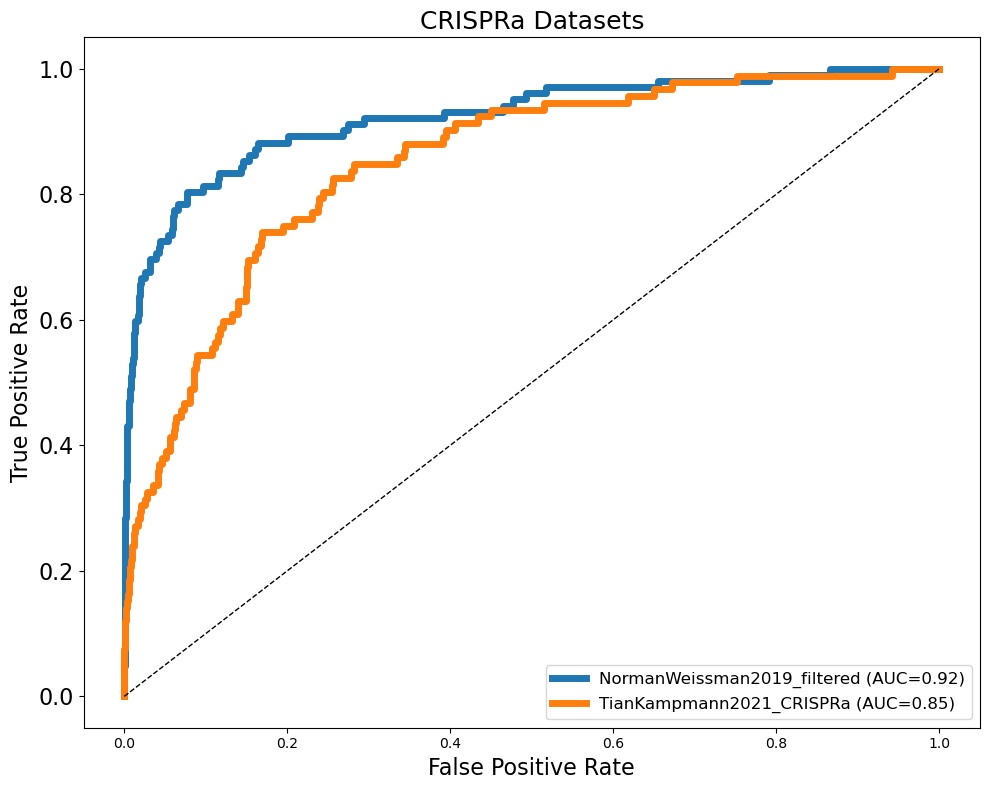

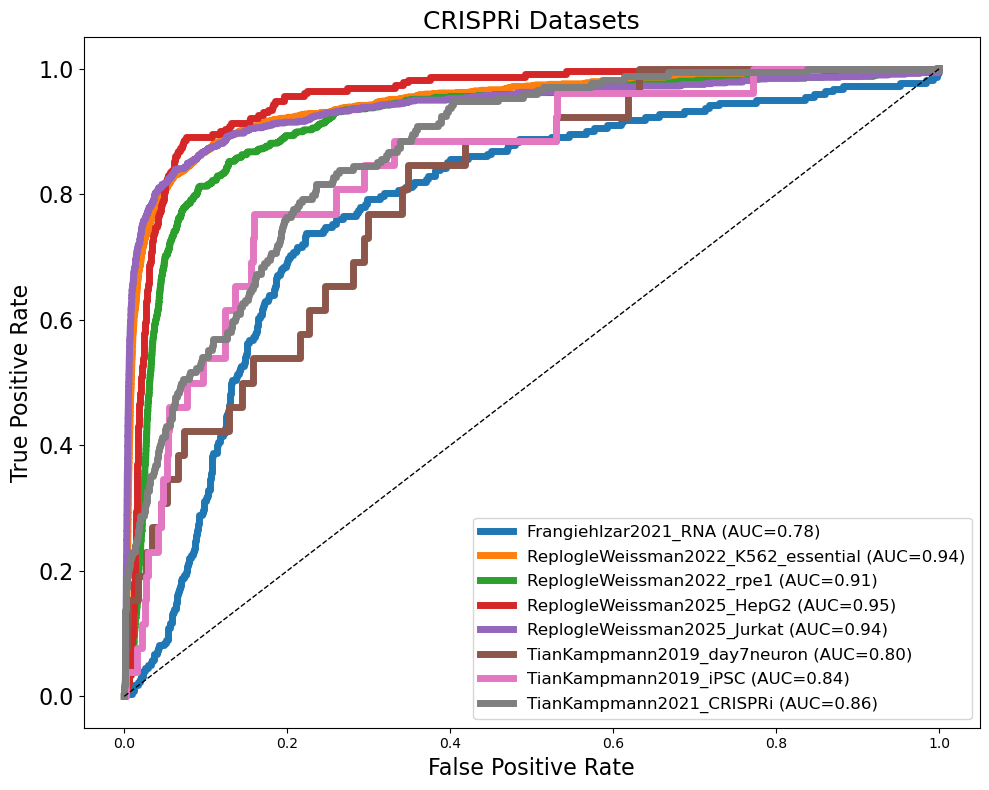

In [7]:
# Fig 4 C and D
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from src.cov import load_u_samples_summary



# Load all .pkl summaries

summary_files = sorted(glob.glob(f"{base_out}/samples_summaries/u_samples_summaries/*.pkl"))
print(f"Found {len(summary_files)} summaries.")

dfs = []
for file in summary_files:
    df = load_u_samples_summary(file)
    df['Dataset'] = os.path.basename(file).replace("_usamples_with_lr.pkl", "")
    df['Path'] = file  # Save original path for classification
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(all_df)} rows total.")

# Split datasets
is_crispra = all_df['Path'].str.contains("CRISPRa|Norman", case=False)
df_a = all_df[is_crispra].copy()
df_i = all_df[~is_crispra].copy()

def plot_u_std_curve(df_subset, title, output_file):
    plt.figure(figsize=(10, 8))
    datasets = df_subset['Dataset'].unique()
    roc_data = []

    for dataset in datasets:
        df = df_subset[df_subset['Dataset'] == dataset]
        if df['IsTruePerturbation'].sum() == 0:
            print(f"Skipping {dataset} (no true perturbations)")
            continue

        optimistic = np.abs(df['U_Mean'] + df['U_Std'])
        pessimistic = np.abs(df['U_Mean'] - df['U_Std'])
        max_up_down = np.maximum(optimistic, pessimistic)

        fpr, tpr, _ = roc_curve(df['IsTruePerturbation'], max_up_down)
        auc_score = roc_auc_score(df['IsTruePerturbation'], max_up_down)

        plt.plot(fpr, tpr, label=f"{dataset} (AUC={auc_score:.2f})", linestyle='-', lw = 5)

        roc_data.append({
            "Dataset": dataset,
            "Metric": "Max_Abs_U_plus_minus_Std",
            "ROC_AUC": auc_score,
            "AveragePrecision": average_precision_score(df['IsTruePerturbation'], max_up_down)
        })

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_file, format='svg')
    plt.show()

    return pd.DataFrame(roc_data)

# Generate and save plots
roc_df_a = plot_u_std_curve(df_a, "CRISPRa Datasets", os.path.join(base_out, "roc_crispra_maxUstd.svg"))
roc_df_i = plot_u_std_curve(df_i, "CRISPRi Datasets", os.path.join(base_out, "roc_crispri_maxUstd.svg"))

# Combine and save
roc_summary = pd.concat([roc_df_a, roc_df_i], ignore_index=True)
roc_summary.to_csv(os.path.join(base_out, "rocauc_summary_maxUstd_CRISPRa_vs_CRISPRi.csv"), index=False)


Processing: FrangiehIzar2021_RNA
Processing: NormanWeissman2019_filtered
Processing: ReplogleWeissman2022_K562_essential
Processing: ReplogleWeissman2022_rpe1
Processing: ReplogleWeissman2025_HepG2
Processing: ReplogleWeissman2025_Jurkat
Processing: TianKampmann2019_day7neuron
Processing: TianKampmann2019_iPSC
Processing: TianKampmann2021_CRISPRa
Processing: TianKampmann2021_CRISPRi
Saved summary to: summary/per_dataset_auroc_summary.csv


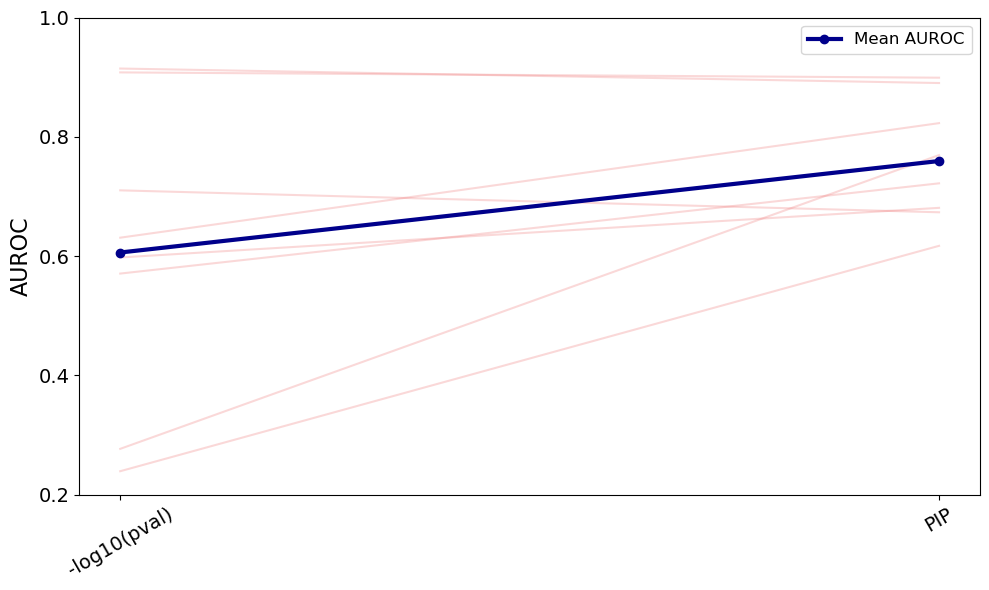

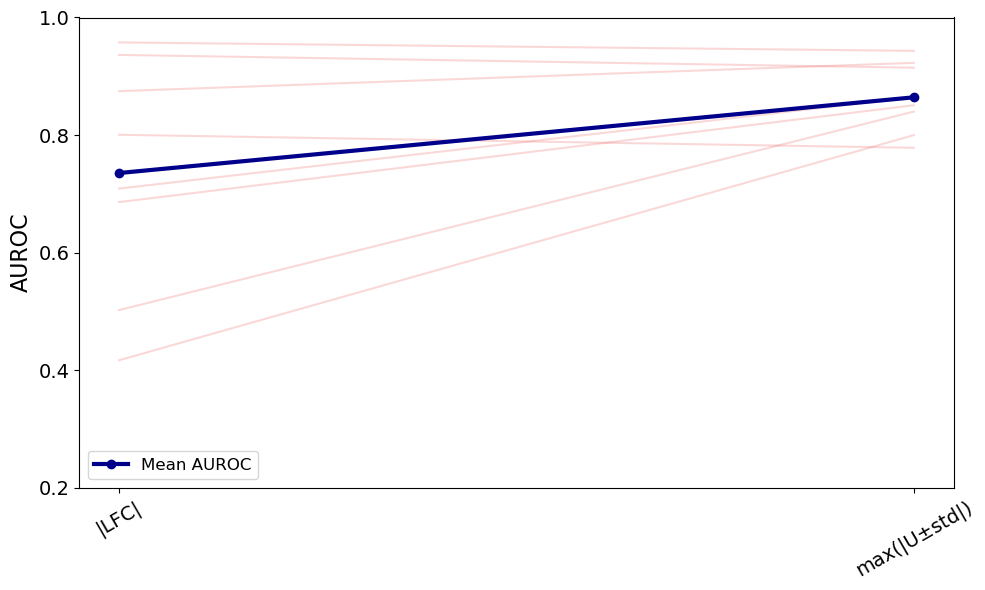

In [8]:
# FIG4 E and F


import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# === Config ===
top_k = 200
summary_outfile = "summary/per_dataset_auroc_summary.csv"
plot_outfile1 = "summary/auroc_comparison_pval_pip.svg"
plot_outfile2 = "summary/auroc_comparison_fc_u_combo.svg"
os.makedirs("summary", exist_ok=True)
os.makedirs("per_dataset_roc_curves", exist_ok=True)

# === Helper Functions ===
def load_u_samples_summary(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

def safe_binary_roc(y_true, scores):
    mask = (~np.isnan(scores)) & (~np.isinf(scores)) & (~pd.isnull(scores))
    clean_y = np.array(y_true)[mask]
    clean_scores = np.array(scores)[mask]
    if np.unique(clean_y).size < 2:
        return None, None, np.nan
    fpr, tpr, _ = roc_curve(clean_y, clean_scores)
    auc = roc_auc_score(clean_y, clean_scores)
    return fpr, tpr, auc

# === Load Data ===
summary_files = sorted(glob.glob(f"{base_out}/samples_summaries/u_samples_summaries/*.pkl"))
posterior_dfs = [load_u_samples_summary(f).assign(Dataset=os.path.basename(f).replace("_usamples_with_lr.pkl", "")) for f in summary_files]
all_post = pd.concat(posterior_dfs, ignore_index=True)

de_files = sorted(glob.glob(f"{base_out}/differential_expression_results/*_differential_expression.csv"))
de_dfs = []
for file in de_files:
    dataset = os.path.basename(file).replace("_differential_expression.csv", "")
    df = pd.read_csv(file)
    df["Dataset"] = dataset
    de_dfs.append(df)
all_de = pd.concat(de_dfs, ignore_index=True)

# === Compute per-dataset AUROCs ===
results = []

for dataset in all_post["Dataset"].unique():
    print(f"Processing: {dataset}")
    post_df = all_post[all_post["Dataset"] == dataset]
    de_df = all_de[all_de["Dataset"] == dataset]

    if post_df.empty or de_df.empty:
        continue

    max_u = np.maximum(np.abs(post_df["U_Mean"] + post_df["U_Std"]), np.abs(post_df["U_Mean"] - post_df["U_Std"]))
    auc_pip = safe_binary_roc(post_df["IsTruePerturbation"], post_df["PIP"])[2]
    auc_maxu = safe_binary_roc(post_df["IsTruePerturbation"], max_u)[2]

    fc_rows, pval_rows = [], []
    for pert in post_df["Perturbation"].unique():
        true_gene = post_df.query("Perturbation == @pert and IsTruePerturbation == 1")["Gene"]
        df = de_df[de_df["Perturbation"] == pert].dropna(subset=["log2FC", "pval"])

        if len(true_gene) == 1 and true_gene.values[0] not in df["Gene"].values:
            extra = de_df[(de_df["Perturbation"] == pert) & (de_df["Gene"] == true_gene.values[0])]
            df = pd.concat([df, extra])

        df["FC_Score"] = np.abs(df["log2FC"])
        df["PVAL_Score"] = -np.log10(df["pval"] + 1e-12)

        df_fc = df.sort_values("FC_Score", ascending=False).head(top_k)
        df_pv = df.sort_values("PVAL_Score", ascending=False).head(top_k)

        if len(true_gene) == 1:
            if true_gene.values[0] not in df_fc["Gene"].values:
                true_row_fc = df[df["Gene"] == true_gene.values[0]].iloc[:1]
                df_fc = pd.concat([df_fc, true_row_fc])
            if true_gene.values[0] not in df_pv["Gene"].values:
                true_row_pv = df[df["Gene"] == true_gene.values[0]].iloc[:1]
                df_pv = pd.concat([df_pv, true_row_pv])

        for _, row in df_fc.iterrows():
            fc_rows.append({"Score": row["FC_Score"], "IsTruePerturbation": int(row["Gene"] == true_gene.values[0])})
        for _, row in df_pv.iterrows():
            pval_rows.append({"Score": row["PVAL_Score"], "IsTruePerturbation": int(row["Gene"] == true_gene.values[0])})

    df_fc = pd.DataFrame(fc_rows)
    df_pval = pd.DataFrame(pval_rows)
    auc_fc = safe_binary_roc(df_fc["IsTruePerturbation"], df_fc["Score"])[2]
    auc_pval = safe_binary_roc(df_pval["IsTruePerturbation"], df_pval["Score"])[2]

    merged = post_df.merge(de_df, on=["Perturbation", "Gene"]).dropna(subset=["log2FC", "U_Mean", "U_Std"])
    max_u_pm = np.maximum(np.abs(merged["U_Mean"] + merged["U_Std"]), np.abs(merged["U_Mean"] - merged["U_Std"]))
    composite = np.abs(merged["log2FC"]) * max_u_pm
    auc_combo = safe_binary_roc(merged["IsTruePerturbation"], composite)[2]

    results.append({
        "Dataset": dataset,
        "|LFC|": auc_fc,
        "max(|U±std|)": auc_maxu,
        "PIP": auc_pip,
        "-log10(pval)": auc_pval,
        "|LFC|×max(|U±std|)": auc_combo,
    })

# Save AUROC summary
summary_df = pd.DataFrame(results)
summary_df.to_csv(summary_outfile, index=False)
print(f"Saved summary to: {summary_outfile}")

# === Plot Set 1: PIP and pval ===
plot_metrics1 = [ "-log10(pval)", "PIP"]
summary_df1 = summary_df.dropna(subset=plot_metrics1)

plt.figure(figsize=(10, 6))
for _, row in summary_df1.iterrows():
    plt.plot(plot_metrics1, [row[m] for m in plot_metrics1], color='lightcoral', alpha=0.3)

mean1 = [summary_df1[m].mean() for m in plot_metrics1]
plt.plot(plot_metrics1, mean1, marker='o', color='darkblue', linewidth=3, label="Mean AUROC")
plt.ylabel("AUROC", fontsize=16)
# plt.title("AUROC: PIP and -log10(pval)", fontsize=18)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
# plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(plot_outfile1, format="svg")
plt.show()

# === Plot Set 2: FC, U±std, combo ===
plot_metrics2 = ["|LFC|", "max(|U±std|)"]
summary_df2 = summary_df.dropna(subset=plot_metrics2)

plt.figure(figsize=(10, 6))
for _, row in summary_df2.iterrows():
    plt.plot(plot_metrics2, [row[m] for m in plot_metrics2], color='lightcoral', alpha=0.3)

mean2 = [summary_df2[m].mean() for m in plot_metrics2]
plt.plot(plot_metrics2, mean2, marker='o', color='darkblue', linewidth=3, label="Mean AUROC")
plt.ylabel("AUROC", fontsize=16)
# plt.title("AUROC: FC, max(|U±std|), and Product", fontsize=18)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(plot_outfile2, format="svg")
plt.show()


In [15]:
# FIG 4 G


import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# === Config ===
summary_outfile = "summary/auroc_comparison_4way.csv"
plot_outfile = "summary/auroc_comparison_4way.svg"
os.makedirs("summary", exist_ok=True)

# === Helper Functions ===
def load_u_samples_summary(filepath, dataset_name):
    with open(filepath, "rb") as f:
        df = pickle.load(f)
    df["Dataset"] = dataset_name
    return df

def safe_binary_roc(y_true, scores):
    mask = (~np.isnan(scores)) & (~np.isinf(scores)) & (~pd.isnull(scores))
    clean_y = np.array(y_true)[mask]
    clean_scores = np.array(scores)[mask]
    if np.unique(clean_y).size < 2:
        return np.nan
    return roc_auc_score(clean_y, clean_scores)

# === Define conditions and directories ===
condition_dirs = {
    "Shuffled Σ": "u_samples_summaries_shuff_Sigma",
    "ZINB": "u_samples_summaries_shuff_Sigma_zinb",
    "Meanfield (shuffled X₀)": "u_samples_summaries_shuff_X0",
    "Real Σ": "u_samples_summaries"
}

results = []

# === Process each condition ===
for condition, dir_path in condition_dirs.items():
    summary_files = sorted(glob.glob(f"output/samples_summaries/{dir_path}/*.pkl"))
    for fpath in summary_files:
        dataset = os.path.basename(fpath).replace("_usamples_with_lr.pkl", "")
        df = load_u_samples_summary(fpath, dataset)
        if not all(col in df for col in ["U_Mean", "U_Std", "IsTruePerturbation"]):
            continue
        df = df.dropna(subset=["U_Mean", "U_Std", "IsTruePerturbation"])
        max_u = np.maximum(np.abs(df["U_Mean"] + df["U_Std"]), np.abs(df["U_Mean"] - df["U_Std"]))
        auc = safe_binary_roc(df["IsTruePerturbation"], max_u)
        results.append({"Dataset": dataset, "Condition": condition, "AUROC": auc})


In [18]:
# === Save summary ===
df_results = pd.DataFrame(results)
df_results.to_csv(summary_outfile, index=False)

# === Plot ===
plt.figure(figsize=(10, 6))
ordered_conditions = list(condition_dirs.keys())
for dataset, group in df_results.groupby("Dataset"):
    group_sorted = group.set_index("Condition").reindex(ordered_conditions)
    plt.plot(group_sorted.index, group_sorted["AUROC"], alpha=0.4, color='lightcoral')

# Plot mean line
mean_auc = df_results.groupby("Condition")["AUROC"].mean().reindex(ordered_conditions)
plt.plot(mean_auc.index, mean_auc.values, marker='o', color='darkblue', linewidth=3, label="Mean AUROC")

plt.ylabel("AUROC", fontsize=16)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(plot_outfile, format="svg")
plt.close()

In [4]:
# Calculating p-values for FIG 4 E and F

import pandas as pd
from scipy.stats import wilcoxon

# Load AUROC summary
summary_df = pd.read_csv("summary/per_dataset_auroc_summary.csv")

# --- Comparison 1: PIP vs -log10(pval) ---
df_pval_vs_pip = summary_df.dropna(subset=["-log10(pval)", "PIP"])
print("\n=== PIP vs -log10(pval) ===")
print(df_pval_vs_pip[["Dataset", "PIP", "-log10(pval)"]])

# Two-sided
stat1, pval1 = wilcoxon(df_pval_vs_pip["PIP"], df_pval_vs_pip["-log10(pval)"])
# One-sided: PIP > pval
pval1_greater = wilcoxon(df_pval_vs_pip["PIP"], df_pval_vs_pip["-log10(pval)"], alternative="greater").pvalue
# One-sided: PIP < pval
pval1_less = wilcoxon(df_pval_vs_pip["PIP"], df_pval_vs_pip["-log10(pval)"], alternative="less").pvalue

print(f"\nTwo-sided Wilcoxon (PIP vs -log10(pval)) — stat: {stat1:.3f}, p = {pval1:.3e}")
print(f"One-sided (PIP > -log10(pval)) — p = {pval1_greater:.3e}")
print(f"One-sided (PIP < -log10(pval)) — p = {pval1_less:.3e}")

# --- Comparison 2: |LFC| vs max(|U±std|) ---
df_lfc_vs_maxu = summary_df.dropna(subset=["|LFC|", "max(|U±std|)"])
print("\n=== |LFC| vs max(|U±std|) ===")
print(df_lfc_vs_maxu[["Dataset", "|LFC|", "max(|U±std|)"]])

# Two-sided
stat2, pval2 = wilcoxon(df_lfc_vs_maxu["|LFC|"], df_lfc_vs_maxu["max(|U±std|)"])
# One-sided: LFC > maxU
pval2_greater = wilcoxon(df_lfc_vs_maxu["|LFC|"], df_lfc_vs_maxu["max(|U±std|)"], alternative="greater").pvalue
# One-sided: LFC < maxU
pval2_less = wilcoxon(df_lfc_vs_maxu["|LFC|"], df_lfc_vs_maxu["max(|U±std|)"], alternative="less").pvalue

print(f"\nTwo-sided Wilcoxon (|LFC| vs max(|U±std|)) — stat: {stat2:.3f}, p = {pval2:.3e}")
print(f"One-sided (|LFC| > maxU) — p = {pval2_greater:.3e}")
print(f"One-sided (|LFC| < maxU) — p = {pval2_less:.3e}")



=== PIP vs -log10(pval) ===
                               Dataset       PIP  -log10(pval)
0                 FrangiehIzar2021_RNA  0.667097      0.710277
1    GSE264667_hepg2_raw_singlecell_01  0.955457      0.882621
2   GSE264667_jurkat_raw_singlecell_01  0.902402      0.914178
3          NormanWeissman2019_filtered  0.665021      0.597797
4  ReplogleWeissman2022_K562_essential  0.899933      0.907991
5            ReplogleWeissman2022_rpe1  0.883312      0.913325
6          TianKampmann2019_day7neuron  0.754613      0.276959
7                TianKampmann2019_iPSC  0.612816      0.239471
8             TianKampmann2021_CRISPRa  0.713813      0.570761
9             TianKampmann2021_CRISPRi  0.816199      0.630918

📊 Two-sided Wilcoxon (PIP vs -log10(pval)) — stat: 10.000, p = 8.398e-02
📈 One-sided (PIP > -log10(pval)) — p = 4.199e-02
📉 One-sided (PIP < -log10(pval)) — p = 9.678e-01

=== |LFC| vs max(|U±std|) ===
                               Dataset     |LFC|  max(|U±std|)
0           

In [5]:
# Calculating p-values for FIG 4 G


from scipy.stats import wilcoxon

# === Load saved results ===
df_results = pd.read_csv("summary/auroc_comparison_4way.csv")

# === Define ordered conditions and comparisons ===
ordered_conditions = ["Shuffled Σ", "ZINB", "Meanfield (shuffled X₀)", "Real Σ"]
pairwise_comparisons = [
    ("Shuffled Σ", "ZINB"),
    ("ZINB", "Meanfield (shuffled X₀)"),
    ("Meanfield (shuffled X₀)", "Real Σ")
]

print("\nWilcoxon signed-rank tests between AUROC conditions:")
for cond1, cond2 in pairwise_comparisons:
    df_pair = df_results[df_results["Condition"].isin([cond1, cond2])]
    df_wide = df_pair.pivot(index="Dataset", columns="Condition", values="AUROC").dropna()
    values1 = df_wide[cond1]
    values2 = df_wide[cond2]

    # Two-sided
    stat, p_two = wilcoxon(values1, values2)
    # One-sided: cond2 > cond1
    p_greater = wilcoxon(values1, values2, alternative="less").pvalue
    # One-sided: cond1 > cond2
    p_less = wilcoxon(values1, values2, alternative="greater").pvalue

    print(f"\n{cond1} vs {cond2} (n={len(df_wide)}):")
    print(f"  Two-sided p = {p_two:.3e}, stat = {stat}")
    print(f"  One-sided (AUROC {cond2} > {cond1}) p = {p_greater:.3e}")
    print(f"  One-sided (AUROC {cond1} > {cond2}) p = {p_less:.3e}")
    print("  Means: %.3f → %.3f" % (values1.mean(), values2.mean()))



📊 Wilcoxon signed-rank tests between AUROC conditions:

Shuffled Σ vs ZINB (n=4):
  Two-sided p = 6.250e-01, stat = 3.0
  One-sided (AUROC ZINB > Shuffled Σ) p = 3.125e-01
  One-sided (AUROC Shuffled Σ > ZINB) p = 8.125e-01
  Means: 0.481 → 0.555

ZINB vs Meanfield (shuffled X₀) (n=4):
  Two-sided p = 1.250e-01, stat = 0.0
  One-sided (AUROC Meanfield (shuffled X₀) > ZINB) p = 6.250e-02
  One-sided (AUROC ZINB > Meanfield (shuffled X₀)) p = 1.000e+00
  Means: 0.555 → 0.809

Meanfield (shuffled X₀) vs Real Σ (n=10):
  Two-sided p = 8.398e-02, stat = 10.0
  One-sided (AUROC Real Σ > Meanfield (shuffled X₀)) p = 4.199e-02
  One-sided (AUROC Meanfield (shuffled X₀) > Real Σ) p = 9.678e-01
  Means: 0.850 → 0.876
